In [1]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering

## **Load dataset & model embeddings**

In [3]:
df = pd.read_csv("../data/Books_with_descriptions.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20500 entries, 0 to 20499
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Book-Title   20500 non-null  object
 1   Image-URL-M  20500 non-null  object
 2   description  20500 non-null  object
dtypes: object(3)
memory usage: 480.6+ KB


In [6]:
df.head(5)

,Book-Title,Image-URL-M,description
0,Classical Mythology,http://images.amazon.com/images/P/0195153448.0...,Classical mythology is a literary genre that e...
1,Clara Callan,http://images.amazon.com/images/P/0002005018.0...,Clara Callan is a novel that explores themes o...
2,Decision in Normandy,http://images.amazon.com/images/P/0060973129.0...,"""Decision in Normandy"" is a historical fiction..."
3,Flu: The Story of the Great Influenza Pandemic...,http://images.amazon.com/images/P/0374157065.0...,"""Flu"" is a non-fiction historical narrative th..."
4,The Mummies of Urumchi,http://images.amazon.com/images/P/0393045218.0...,The Mummies of Urumchi is a dark fantasy novel...


In [7]:
embedding = np.load('models/book_recommender/book_embeddings.npy')
print(embedding.shape)

(20500, 768)


In [8]:
embedding

array([[-0.48323452, -0.63045126, -0.27429053, ..., -0.5524434 ,
        -0.06434014,  0.4809102 ],
       [-0.5721574 , -0.32970166, -0.46543077, ..., -0.1348713 ,
         0.6650219 ,  0.0895984 ],
       [-0.08327475, -0.59503865, -0.26940566, ..., -0.12976956,
         0.7114719 , -0.08977744],
       ...,
       [-0.5749625 , -0.2832783 , -0.44136843, ..., -0.16619748,
         0.51798594, -0.01722334],
       [-0.48793387, -0.68244696, -0.08645076, ...,  0.18550678,
         0.44163454, -0.24960586],
       [-0.50503147, -0.47481635, -0.3510071 , ..., -0.14998913,
         0.6591594 ,  0.3403441 ]], dtype=float32)

## **Add genre based on book description**

In [9]:
df["genre"] = ''

In [10]:
df.iloc[0]

,0
Book-Title,Classical Mythology
Image-URL-M,http://images.amazon.com/images/P/0195153448.0...
description,Classical mythology is a literary genre that e...
genre,


In [11]:
def extract_genre(description: str) -> str:
    """Extract genre from book description."""

    # Common genre keywords to look for
    # genres = {
    #     'fantasy': ['fantasy', 'magical', 'magic', 'dragons', 'fairy', 'children', 'kids', 'picture book', 'bedtime'],
    #     'adventure': ['adventure', 'survival', 'action', 'heroic'],
    #     'comedy': ['comedy', 'humor', 'funny', 'hilarious', 'lighthearted', 'wit', 'amusing', 'jokes'],
    #     'romance': ['romance', 'romantic', 'love', 'relationship', 'affection', 'couple', 'intimacy', 'dating'],
    #     'mystery': ['mystery', 'thriller', 'detective', 'crime', 'suspense', 'investigation', 'clues', 'case'],
    #     'horror': ['horror', 'dark', 'supernatural', 'fear', 'haunted', 'ghost', 'terror', 'spooky'],
    #     'science fiction': ['science fiction', 'sci-fi', 'scifi', 'space', 'alien', 'robot', 'time travel', 'technological' ],
    #     'mythology': ['mythology', 'mythological', 'myths', 'god', 'goddess'],
    #     'historical': ['historical', 'history', 'war', 'revolution', 'ancient', 'medieval', 'renaissance', 'colonial'],
    #     'non-fiction': ['non-fiction', 'nonfiction', 'essay', 'documentary', 'true story'],
    #     'literary': ['literary', 'literature', 'classic', 'poetry', 'critique'],
    #     'biography': ['biography', 'biographical', 'life story', 'autobiography'],
    #     'drama': ['drama', 'dramatic', 'conflict', 'emotional', 'tragedy'],
    #     'fiction': ['fiction', 'imaginary', 'fictional']
    # }

    genres = {
        'fantasy': ['fantasy', 'magical', 'magic', 'dragons', 'fairy', 'children', 'kids', 'picture book', 'bedtime'],
        'drama': ['drama', 'dramatic', 'conflict', 'emotional', 'tragedy', 'adventure', 'survival', 'action', 'heroic'],
        'rom-com': ['romance', 'romantic', 'love', 'relationship', 'couple', 'dating', 'comedy', 'humor', 'funny', 'hilarious'],
        'thriller': ['mystery', 'thriller', 'crime', 'suspense', 'investigation', 'horror', 'supernatural', 'fear', 'haunted', 'ghost'],
        'historical': ['mythology', 'mythological', 'myths', 'historical', 'history', 'war', 'revolution', 'ancient', 'medieval', 'renaissance', 'colonial'],
        'non-fiction': ['non-fiction', 'nonfiction', 'essay', 'documentary', 'true story', 'biography', 'biographical', 'life story', 'autobiography'
                        'literature', 'classic', 'poetry', 'critique'],
    }

    description = description.lower()

    # First look for explicit genre mentions
    for genre, keywords in genres.items():
        for keyword in keywords:
            if keyword in description:
                return genre

    # Default to 'fiction' if no genre is found
    return 'fiction'

In [12]:
df['genre'] = df['description'].apply(extract_genre)

In [13]:
df

,Book-Title,Image-URL-M,description,genre
0,Classical Mythology,http://images.amazon.com/images/P/0195153448.0...,Classical mythology is a literary genre that e...,historical
1,Clara Callan,http://images.amazon.com/images/P/0002005018.0...,Clara Callan is a novel that explores themes o...,rom-com
2,Decision in Normandy,http://images.amazon.com/images/P/0060973129.0...,"""Decision in Normandy"" is a historical fiction...",historical
3,Flu: The Story of the Great Influenza Pandemic...,http://images.amazon.com/images/P/0374157065.0...,"""Flu"" is a non-fiction historical narrative th...",historical
4,The Mummies of Urumchi,http://images.amazon.com/images/P/0393045218.0...,The Mummies of Urumchi is a dark fantasy novel...,fantasy
...,...,...,...,...
20495,War Letters : Extraordinary Correspondence fro...,http://images.amazon.com/images/P/0743410068.0...,War Letters is a collection of personal letter...,historical
20496,The Burglar in the Rye: A Bernie Rhodenbarr My...,http://images.amazon.com/images/P/0451198476.0...,"In ""The Burglar in the Rye,"" a clever and char...",thriller
20497,Karen's Little Witch (Baby-Sitters Little Sist...,http://images.amazon.com/images/P/0590448331.0...,Karen's Little Witch is a fantasy novel that f...,fantasy
20498,Jelly Belly,http://images.amazon.com/images/P/0440442079.0...,"Jelly Belly is a sugary, colorful, and chewy c...",fiction


## **UMAP Analysis**

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


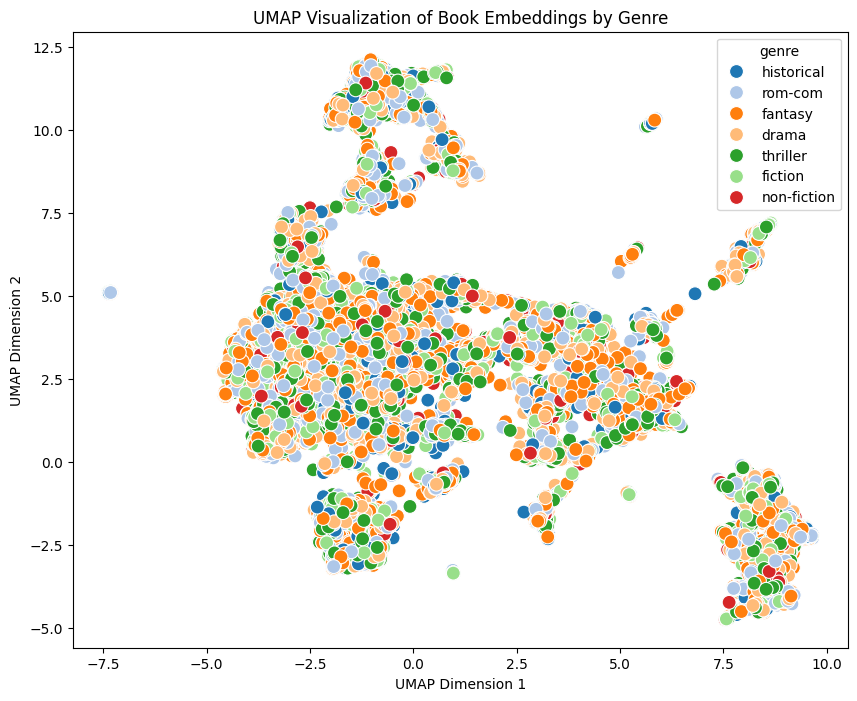

In [14]:
# reduce embeddings
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_embeddings = umap_model.fit_transform(embedding)

df['umap_x'] = umap_embeddings[:, 0]
df['umap_y'] = umap_embeddings[:, 1]

# plot umap visualization of book embeddings by genre
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='umap_x', y='umap_y', hue='genre', palette='tab20', legend='full', s=100)
plt.title('UMAP Visualization of Book Embeddings by Genre')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

In [15]:
# books per genre
genre_counts = df['genre'].value_counts()

print("Books per genre:")
print(genre_counts)

genre_centroids = df.groupby('genre')[['umap_x', 'umap_y']].mean()

Books per genre:
genre
fantasy        4493
drama          4476
rom-com        3450
thriller       2932
fiction        2693
historical     1574
non-fiction     882
Name: count, dtype: int64


In [17]:
# closest book in each genre
def find_closest_books(genre, n=5):
  centroid = genre_centroids.loc[genre]
  genre_df = df[df['genre'] == genre]
  distances = np.sqrt((genre_df['umap_x'] - centroid['umap_x'])**2 + (genre_df['umap_y'] - centroid['umap_y'])**2)
  return genre_df.iloc[distances.argsort()[:n]]

for genre in genre_centroids.index:
  print(f"\nClosest books to {genre} centroid:")
  closest_books = find_closest_books(genre)
  print(closest_books[['Book-Title', 'genre']])


Closest books to drama centroid:
                                              Book-Title  genre
4319   My Sister from the Black Lagoon : A Novel of M...  drama
14478                                    Made in America  drama
18410  Cutting: Understanding and Overcoming Self-Mut...  drama
8436   Wish You Were Here (Mrs. Murphy Mysteries (Pap...  drama
8758                                               Twins  drama

Closest books to fantasy centroid:
                                Book-Title    genre
15922                    The Knight's Kiss  fantasy
15696                          Lady Oracle  fantasy
3935                        The Blue Sword  fantasy
16622                          BRAIN CHILD  fantasy
3683   Kushiel's Avatar (Kushiel's Legacy)  fantasy

Closest books to fiction centroid:
                                              Book-Title    genre
3219                              Sans nouvelles de Gurb  fiction
9799   Dictionary of Word Origins : Histories of More...  fiction


## **Agglomerative-Clustering Analysis**

In [18]:
# perform clustering
hierarchical = AgglomerativeClustering(n_clusters=5, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(embedding)

In [19]:
# dimensionality reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
reduced_embeddings = tsne.fit_transform(embedding)

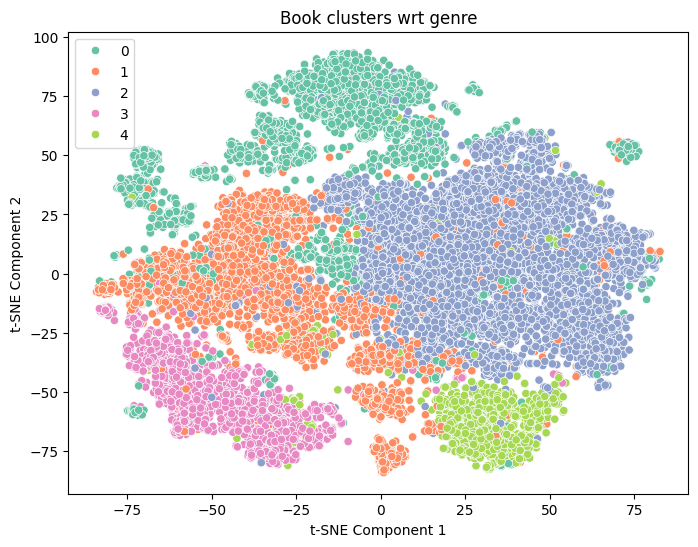

In [20]:
# plot  clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=reduced_embeddings[:, 0],
    y=reduced_embeddings[:, 1],
    hue=hierarchical_labels,
    palette='Set2',
    legend='full'
)
plt.title('Book clusters wrt genre')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [26]:
df['hierarchical_cluster'] = hierarchical_labels

def get_top_books_in_cluster(df, cluster_column, cluster_id, n=5):
    cluster_books = df[df[cluster_column] == cluster_id].copy()
    cluster_embeddings = embedding[df[cluster_column] == cluster_id]
    centroid = np.mean(cluster_embeddings, axis=0)

    distances = [np.linalg.norm(emb - centroid) for emb in cluster_embeddings]
    cluster_books.loc[:,'distance_to_centroid'] = distances

    return cluster_books.sort_values('distance_to_centroid').head(n)

for cluster in set(hierarchical_labels):
    print(f"\nTop 5 books in Hierarchical Cluster {cluster}:")
    top_books = get_top_books_in_cluster(df, 'hierarchical_cluster', cluster)
    print(top_books[['Book-Title']])


Top 5 books in Hierarchical Cluster 0:
                                              Book-Title
8843   Lost Tribes and Promised Lands: The Origins of...
10396                                       The Vor Game
6547    The Probable Future (Ballantine Reader's Circle)
17323                            The Catsitters: A Novel
3086   Shadowrun: Find Your Own Truth (Secrets of Pow...

Top 5 books in Hierarchical Cluster 1:
                                       Book-Title
16850  When I Am an Old Woman I Shall Wear Purple
9025                                    Butterfly
15848                                 Plain Truth
12410                       River of Dancing Gods
16752                                In His Steps

Top 5 books in Hierarchical Cluster 2:
                                              Book-Title
5940   Stone Kiss (Peter Decker &amp; Rina Lazarus No...
19727  To See You Again (The Penguin Contemporary Ame...
5715           The Civil War (American Heritage Library)
10715     